## Импортируем нужные для анализа данных библиотеки

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [31]:
# Прочитаем датасет из csv файла и посмотрим на его размер
dataset = pd.read_csv('dataset.csv')
dataset.shape

(7043, 21)

## Смотрим на данные глазами и поправляем их при необходимости

Что понятно:
1) Каждая строчка - клиент с какими-то признаками (20 столбцов)
2) Целевая переменная - churn (ушел клиент или нет)

In [32]:
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [33]:
# Заменим названия столбцов для совместимости с базой данных
dataset.rename(columns = {'SeniorCitizen': 'senior_citizen', 'Partner': 'partner', 'Dependents': 'dependents', 'PhoneService': 'phone_service','MultipleLines': 'multiplelines','InternetService': 'internet_service','OnlineSecurity': 'online_security','OnlineBackup': 'online_backup', 'DeviceProtection': 'device_protection','TechSupport': 'techsupport','StreamingTV': 'streaming_tv','StreamingMovies': 'streaming_movies','Contract': 'contract','PaperlessBilling': 'paperless', 'PaymentMethod': 'payment_method', 'MonthlyCharges': 'monthly_charges', 'TotalCharges': 'total_charges', 'Churn': 'churn', 'customerID': 'customer_id'}, inplace=True)

In [34]:
#Нужно заменить пустые строки в столбце TotalCharges на nan
dataset['total_charges'] = dataset["total_charges"].replace(" ",np.nan)
#Дропаем строки с пропущенными значениями TotalCharges (их всего несколько штук - нестрашно)
dataset = dataset[dataset["total_charges"].notnull()]
dataset = dataset.reset_index()[dataset.columns]

#переведем вещественные и целые числа к нужному типу
dataset["total_charges"] = dataset["total_charges"].astype(float)
dataset["monthly_charges"] = dataset["monthly_charges"].astype(float)
dataset["tenure"] = dataset["tenure"].astype(int)

#а здесь наоборот переводим в булеву переменную (да/нет)
dataset["senior_citizen"] = dataset["senior_citizen"].replace({1:True,0:False})
dataset["partner"] = dataset["partner"].replace({'Yes':True,'No':False})
dataset["dependents"] = dataset["dependents"].replace({'Yes':True,'No':False})
dataset["phone_service"] = dataset["phone_service"].replace({'Yes':True,'No':False})
dataset["paperless"] = dataset["paperless"].replace({'Yes':True,'No':False})
dataset["churn"] = dataset["churn"].replace({'Yes':True,'No':False})

#заменяем значения на аналогичные в базе данных
dataset["online_security"] = dataset["online_security"].replace({'No internet service': 'NO_INTERNET'})
dataset["device_protection"] = dataset["device_protection"].replace({'No internet service': 'NO_INTERNET'})
dataset["online_backup"] = dataset["online_backup"].replace({'No internet service': 'NO_INTERNET'})
dataset["streaming_movies"] = dataset["streaming_movies"].replace({'No internet service': 'NO_INTERNET'})
dataset["streaming_tv"] = dataset["streaming_tv"].replace({'No internet service': 'NO_INTERNET'})
dataset["multiplelines"] = dataset["multiplelines"].replace({'No phone service': 'NO_PHONE'})
dataset["techsupport"] = dataset["techsupport"].replace({'No internet service': 'NO_INTERNET'})
dataset["payment_method"] = dataset["payment_method"].replace({'Bank transfer (automatic)': 'Bank transfer', 'Credit card (automatic)': 'Credit card' })

In [35]:
#разделяем колонки на два типа (категориальные и вещественные). Зависимую переменную преобразуем потом
numeric_cols = ["tenure", "monthly_charges", "total_charges"]
categorical_cols = list(set(dataset.columns.values.tolist()) - set(numeric_cols) - set(["churn","customer_id"]))
print(categorical_cols)

['partner', 'senior_citizen', 'paperless', 'online_security', 'device_protection', 'gender', 'internet_service', 'phone_service', 'payment_method', 'contract', 'dependents', 'online_backup', 'streaming_tv', 'multiplelines', 'streaming_movies', 'techsupport']


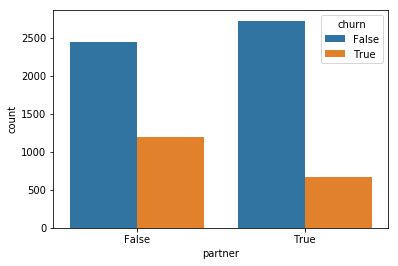

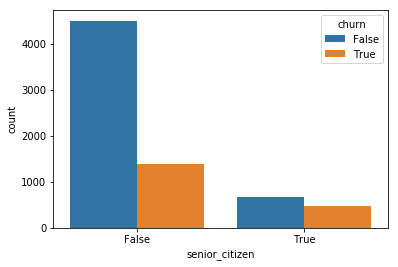

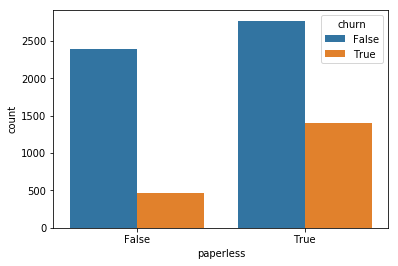

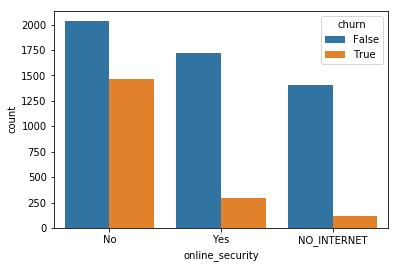

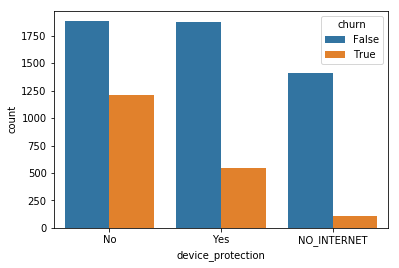

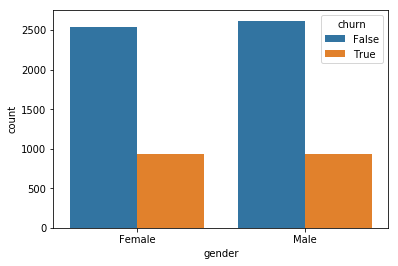

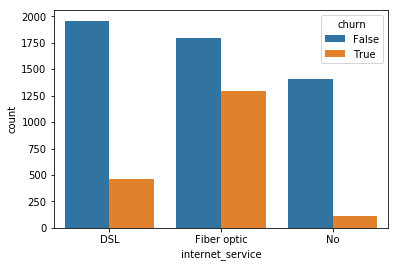

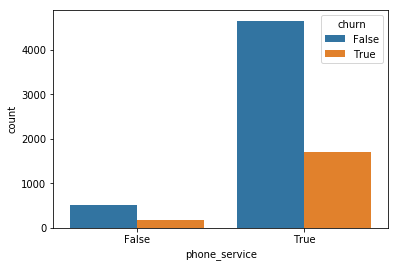

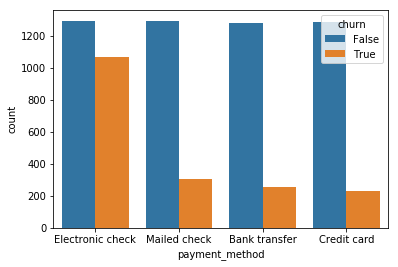

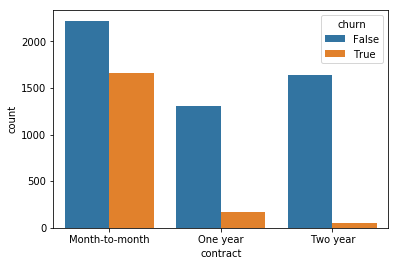

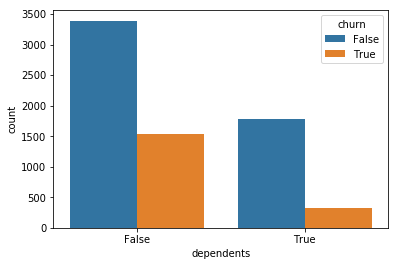

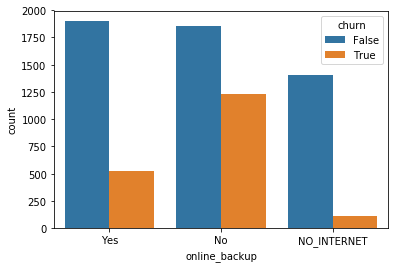

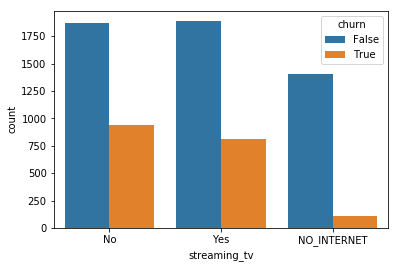

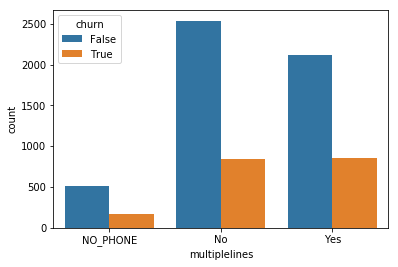

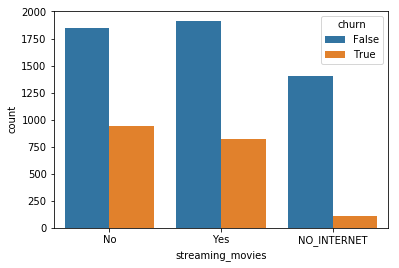

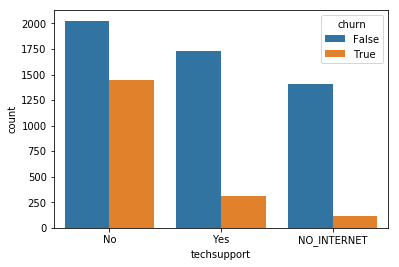

In [36]:
# красиво кучу графиков нарисовать не смог, сорри ¯\_(ツ)_/¯
# Графики подсказывают распределение отточников по признакам
# Например сразу видно, что среди тех, у кого нет Online Backup процент отточников выше
for var in categorical_cols:
    ax = sns.countplot(x=var,hue="churn", data=dataset)
    i =+1
    plt.show()

In [37]:
# Разделим датасет на целевую переменную и зависимые
X = dataset.drop(columns=['churn'])
Y = dataset['churn']

# X дополнительно разделим на категориальные и вещественные переменные
X_number = X[numeric_cols]
X_categ = X[categorical_cols]
#на всякий случай все категориальные приведем к строке (вроде они и так строки)
X_categ = X_categ.astype(str)

# Энкодер категориальных переменных

In [38]:
from sklearn.feature_extraction import DictVectorizer as DV

encoder = DV(sparse = False)
# Преобразуем категориальные переменные в множество бинарных признаков с помощью one hot encoder
encoder.fit(X_categ.T.to_dict().values())
X_categ_encoded = encoder.transform(X_categ.T.to_dict().values())
# Преобразуем зависимую переменную в множество бинарных признаков с помощью one hot encoder
Y_encoded = np.asarray(Y)

## Скейлер вещественных переменных

In [39]:
from sklearn.preprocessing import StandardScaler

#нормализуем вещественные признаки (приводим к виду от 0 до 1)
scaler = StandardScaler()
scaler.fit(X_number)
X_number_scaled = scaler.transform(X_number)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [40]:
#теперь можно сконкатенировать по горизонтали категориальные и вещественные фичи и получить окончательный датасет
X_finish = np.hstack ((X_number_scaled, X_categ_encoded))

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

# Функция для обучения модели
# Принимает переменные, параметры модели, вовзращает лучшую найденную по параметрам модель
def learning_model(X, Y, clf, param_grid, scoring):
    # Разделим выборки на test, train
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    # Зададим classifier и сетку параметров
    gridCV = GridSearchCV(clf, param_grid, scoring = scoring, cv = 3)
    # Обучим по сетке
    gridCV.fit(X_train, y_train)
    # Получим предсказания алгоритма
    predictions = gridCV.predict_proba(X_test)[:,1]
    # Получим значения fpr и tpr для roc_curve
    fpr,tpr,thresholds = roc_curve(y_test,predictions)
    
    #построим график ROC кривой
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.set(xlabel='FPR', ylabel='TPR', title='ROC-CURVE')
    ax.grid()
    plt.show()

    print (roc_auc_score(y_test, predictions))
    print (gridCV.best_score_)
    return gridCV.best_estimator_

## Для начала попробую построить логистическую регрессию

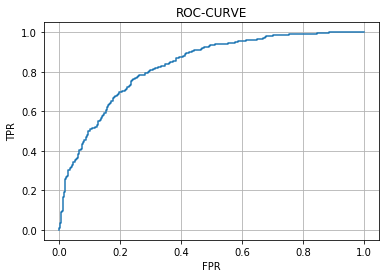

0.8317035165733987
0.8480693749676247


In [42]:
# Зададим сетку параметров для модели
param_grid_logreg = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20], 'class_weight':['balanced', None],'penalty':['l2'],  }
clf_log = LogisticRegression(solver='liblinear')
# Обучим модель на данных и классификатора выше
log_reg = learning_model(X_finish, Y_encoded, clf_log, param_grid_logreg, scoring = 'roc_auc')

В качестве метрики будем использовать площадь под AUC кривой (чтобы можно было сравнить разные алгоритмы между собой)

# Попробуем запустить случайный лес и градиентный бустинг

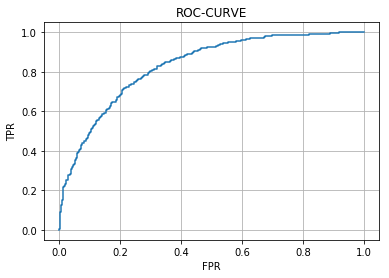

0.8305956898292187
0.8461053298370247


In [43]:
from sklearn import ensemble 
# Зададим classifier и сетку параметров
param_grid_rf = {'n_estimators': [1] + list(range(10, 55, 5)), 'min_samples_split': range(2, 25, 2)}
estimator_rf = ensemble.RandomForestClassifier(random_state=0)
# Обучим модель на данных и классификатора выше
rf_model = learning_model(X_finish, Y_encoded, estimator_rf, param_grid_rf, scoring = 'roc_auc')

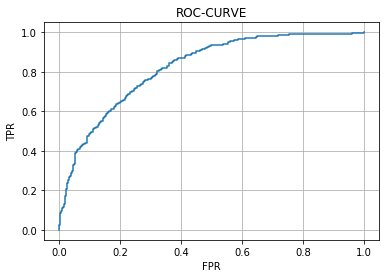

0.8213939980638916
0.8357869748857374


In [44]:
import xgboost as xgb

# Подбор параметров для градиентого бустинга - максимальная глубина дерева, количество деревьев, шаг градиента
param_grid_boosting = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1, 0.16],}
estimator_boosting = xgb.XGBClassifier()

# Обучим модель на данных и классификатора выше
boost_model = learning_model(X_finish, Y_encoded, estimator_boosting, param_grid_boosting, scoring = 'roc_auc')

## Экспортируем лучшую модель и энкодеры

In [45]:
import pickle
from joblib import dump, load

best_ensemble = log_reg
dump(best_ensemble, 'model.joblib')
dump(encoder, 'encoder.joblib') 
dump(scaler, 'scaler.joblib') 

['scaler.joblib']

## Предскажем для всех клиентов из датасета вероятность оттока и сохраним столбец в датасет

In [47]:
dataset['probability'] = best_ensemble.predict_proba(X_finish)[:, 0]

In [48]:
dataset.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiplelines,internet_service,online_security,...,techsupport,streaming_tv,streaming_movies,contract,paperless,payment_method,monthly_charges,total_charges,churn,probability
0,7590-VHVEG,Female,False,True,False,1,False,NO_PHONE,DSL,No,...,No,No,No,Month-to-month,True,Electronic check,29.85,29.85,False,0.353234
1,5575-GNVDE,Male,False,False,False,34,True,No,DSL,Yes,...,No,No,No,One year,False,Mailed check,56.95,1889.50,False,0.965901
2,3668-QPYBK,Male,False,False,False,2,True,No,DSL,Yes,...,No,No,No,Month-to-month,True,Mailed check,53.85,108.15,True,0.706219
3,7795-CFOCW,Male,False,False,False,45,False,NO_PHONE,DSL,Yes,...,Yes,No,No,One year,False,Bank transfer,42.30,1840.75,False,0.977481
4,9237-HQITU,Female,False,False,False,2,True,No,Fiber optic,No,...,No,No,No,Month-to-month,True,Electronic check,70.70,151.65,True,0.318714


## Предскажем для тестового JSON

In [2]:
import pandas as pd
dataset_new = pd.read_json('data_test_predict.json')

In [3]:
dataset_new

,contract,customer_id,dependents,device_protection,gender,internet_service,monthly_charges,multiplelines,online_backup,online_security,paperless,partner,payment_method,phone_service,senior_citizen,streaming_movies,streaming_tv,techsupport,tenure,total_charges
0,Month-to-month,qwefasd,False,NO_INTERNET,Male,Fiber optic,23.56,NO_PHONE,NO_INTERNET,NO_INTERNET,False,False,Electronic check,False,False,NO_INTERNET,NO_INTERNET,NO_INTERNET,24,45.67


In [9]:
# разделяем колонки на два типа (категориальные и вещественные).
from joblib import load
import numpy as np
numeric_cols = ["tenure", "monthly_charges", "total_charges"]
categorical_cols = list(set(dataset_new.columns.values.tolist()) - set(numeric_cols) - set(["churn","customer_id"]))

# X дополнительно разделим на категориальные и вещественные переменные
X_number = dataset_new[numeric_cols]
X_categ = dataset_new[categorical_cols]

encoder = load('encoder.joblib')
# Преобразуем категориальные переменные к вещественному виду
X_categ_encoded = encoder.transform(X_categ.T.to_dict().values())

# нормализуем вещественные признаки
#scaler = StandardScaler()
scaler = load('scaler.joblib')
X_number_scaled = scaler.transform(X_number)

# и получим окончательный датасет
X_finish = np.hstack((X_number_scaled, X_categ_encoded))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [10]:
our_model = load('model.joblib')
# возвращаем только вероятности отвала
our_model.predict_proba(X_finish)[:, 0]

array([0.53133539])